## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [2]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [3]:
print("The length of the original data with all rows is: {}".format(len(original_data)))
original_data.dropna(inplace=True) # inplace=True 的作用是直接修改原始数据框，而不是返回一个新的数据框
print("The length of the original data without na rows is: {}".format(len(original_data)))

The length of the original data with all rows is: 79672
The length of the original data without na rows is: 79661


In [6]:
original_data.sample(5)

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
17446,Transfer,Intact Female,0.821918,Cat,Other,Public Assist,Intact Female,0.739726,2014,1.0,16.002778
26973,Adoption,Spayed Female,2.000000,Dog,Normal,Owner Surrender,Intact Female,2.000000,2015,1.0,8.961111
21833,Transfer,Neutered Male,7.000000,Dog,Normal,Owner Surrender,Intact Male,7.000000,2014,1.0,17.174306
36551,Return to Owner,Intact Male,5.000000,Dog,Normal,Stray,Intact Male,5.000000,2016,1.0,0.036806
53156,Return to Owner,Neutered Male,1.000000,Dog,Normal,Stray,Neutered Male,1.000000,2016,3.0,1.801389


In [9]:
data_features = original_data.copy()
data_features['adopted'] = data_features.outcome_type.apply(lambda r: 1 if r == 'Adoption' else 0)
data_features.drop('outcome_type', axis = 1, inplace = True) # axis = 1 表示删除列
data_features.sample(5)

,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted
71710,Neutered Male,0.164384,Cat,Normal,Stray,Intact Male,0.082192,2017,1.0,44.757639,1
6620,Neutered Male,2.000000,Dog,Normal,Stray,Intact Male,2.000000,2013,1.0,3.154167,0
37571,Neutered Male,0.164384,Dog,Normal,Stray,Intact Male,0.013699,2015,1.0,60.211111,1
64847,Intact Male,13.000000,Dog,Normal,Public Assist,Intact Male,13.000000,2017,1.0,10.759028,0
6716,Neutered Male,1.000000,Cat,Normal,Owner Surrender,Neutered Male,1.000000,2013,1.0,3.010417,0


In [10]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

np.random.rand(len(data_to_split)): 生成一个长度等于 data_to_split 的随机数组，其中的每个值都是 [0,1) 之间的随机数。例如，如果 len(data_to_split) = 5，可能生成的数组是 [0.1, 0.8, 0.3, 0.5, 0.2]。

< ratio: 将这些随机数与 ratio 进行比较，生成一个布尔掩码（mask）。每个位置的布尔值取决于对应的随机数是否小于 0.8。例如：如果 ratio=0.8，随机数为 [0.1, 0.8, 0.3, 0.5, 0.2]，结果布尔掩码为 [True, False, True, True, True]。

data_to_split[mask]：使用布尔索引选择 mask 中为 True 的数据，形成第一部分数据（训练集）。

data_to_split[~mask]：使用 ~mask（取反运算）选择 mask 中为 False 的数据，形成第二部分数据（测试集）。

reset_index(drop=True)：删除原有索引，并将新数据的索引重新排列为从 0 开始的连续数字。例如，如果原数据集的索引是 [2, 3, 7, 10]，使用 reset_index(drop=True) 后会变为 [0, 1, 2, 3]。drop=True 的作用是避免旧索引被保留为新列。

In [11]:
[train, test] = split_set(data_features, 0.8)

In [13]:
categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake']
train_categorical = pd.get_dummies(train, columns= categorical_columns)
train_categorical.columns

Index(['age_upon_outcome_(years)', 'age_upon_intake_(years)', 'intake_year',
       'intake_number', 'time_in_shelter_days', 'adopted',
       'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male',
       'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female',
       'sex_upon_outcome_Unknown', 'animal_type_Bird', 'animal_type_Cat',
       'animal_type_Dog', 'animal_type_Other', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife',
       'sex_upon_intake_Intact Female', 'sex_upon_intake_Intact Male',
       'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female',
       'sex_upon_intake_Unknown'],
      dtype='object')

In [14]:
test_categorical = pd.get_dummies(test, columns= categorical_columns)[train_categorical.columns] # 保证test集的列和train集匹配

In [15]:
train_label = train_categorical.adopted
train_features = train_categorical.drop('adopted', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label = test_categorical.adopted
test_features = test_categorical.drop('adopted', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 63647
Length of the test dataset : 16014


对训练集和测试集中的特征值进行标准化，使每个特征的均值为 0，标准差为 1。

In [16]:
means = train_features.mean()
stddevs = train_features.std()

# train_features里每列的值都进行标准化，因为广播机制的存在，所以可以做到1维-0维不报错
train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/ stddevs[c]

# 重要：测试集需要使用训练集的均值和标准差进行标准化
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c] - means[c]) / stddevs[c]

train_features_std.head()

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,2.716652,2.735121,1.202541,-0.278904,-0.381980,-0.363793,-0.37101,1.347484,-0.688292,-0.305801,...,-0.056003,-0.48249,-0.258718,0.652320,-0.214033,-0.650975,-0.682795,2.307002,-0.404639,-0.305801
1,1.680403,1.696433,-1.100882,1.935590,-0.366286,-0.363793,-0.37101,1.347484,-0.688292,-0.305801,...,-0.056003,-0.48249,3.865153,-1.532965,-0.214033,-0.650975,-0.682795,2.307002,-0.404639,-0.305801
2,2.716652,2.735121,-1.100882,-0.278904,-0.279571,-0.363793,-0.37101,1.347484,-0.688292,-0.305801,...,-0.056003,2.07255,-0.258718,-1.532965,-0.214033,-0.650975,-0.682795,2.307002,-0.404639,-0.305801
3,4.789150,4.812495,-1.868690,-0.278904,-0.392935,-0.363793,-0.37101,1.347484,-0.688292,-0.305801,...,-0.056003,-0.48249,3.865153,-1.532965,-0.214033,-0.650975,-0.682795,2.307002,-0.404639,-0.305801
4,4.443733,4.466266,-1.868690,-0.278904,-0.375374,-0.363793,-0.37101,-0.742112,1.452848,-0.305801,...,-0.056003,-0.48249,-0.258718,0.652320,-0.214033,-0.650975,-0.682795,-0.433456,2.471301,-0.305801


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

confusion matrix: 混淆矩阵是一个 2x2 矩阵，用来表示分类器在正类和负类上的预测结果与真实标签的对应关系。

true_label:一维数组，表示真实的标签值（通常是二元分类，取值为 0 或 1）。例如：[0, 1, 1, 0]。

prediction_proba:二维数组，表示分类器对样本的预测概率。假设有 n 个样本，每一行是 [P(0), P(1)]，表示该样本属于类别 0 和 1 的概率。例如：[[0.7, 0.3], [0.2, 0.8], ...]。

decision_threshold=0.5: 决策阈值，用于将预测概率转换为二元分类的预测标签。默认值为 0.5，即当 P(1) > 0.5 时，将样本预测为正类（1）；否则预测为负类（0）。

prediction_proba[:, 1]：提取分类器对每个样本预测为正类（1）的概率。

> decision_threshold：如果概率大于阈值（默认为 0.5），将其标记为 True，否则标记为 False。

.astype(int)：将布尔值转换为整数（True → 1, False → 0）。

In [30]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold):
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)

    TP = np.sum(np.logical_and(predict_label==1, true_label==1)) # True Positives
    TN = np.sum(np.logical_and(predict_label==0, true_label==0)) # True Negatives
    FP = np.sum(np.logical_and(predict_label==1, true_label==0)) # False Positives
    FN = np.sum(np.logical_and(predict_label==0, true_label==1)) # False Negatives

    confusion_matrix = np.asarray([[TP, FP], [FN, TN]])

    return confusion_matrix

对输入的混淆矩阵进行可视化，并在热力图中标注每个矩阵元素的具体含义（如 TP、FP、FN、TN）

[[TP, FP], [FN, TN]] = confusion_matrix : 将 confusion_matrix 的值按顺序解构为 TP、FP、FN、TN。

df_cm: 将混淆矩阵转换为一个 Pandas 数据框，方便后续使用 Seaborn 绘制热力图。例如：

                        Acutally Positive  Actually Negative
Predicted Positive              3                  2
Predicted Negative              1                  4

cmap='YlOrRd': 指定热力图的颜色映射（colormap），用于设置单元格颜色的渐变范围。'YlOrRd' 代表黄色到红色的渐变：小值显示为黄色。大值显示为红色。渐变颜色反映了混淆矩阵中的数值大小。

annot 用于在热力图中每个单元格中显示具体的文字信息。

cbar=False: 用于是否显示热力图右侧的颜色条（Colorbar）。这里设置为 False，表示不显示颜色条。原因是混淆矩阵的数值本身就很直观，颜色条并不必要。

fmt='': 用于设置标注信息的格式（format）。这里设置为 ''，表示不对标注信息进行格式化。

In [31]:
def plot_confusion_matrix(confusion_matrix):
    [[TP,FP],[FN,TN]] = confusion_matrix
    label = np.asarray([["TP {}".format(TP), "FP {}".format(FP)], ["FN {}".format(FN), "TN {}".format(TN)]])

    df_cm = pd.DataFrame(confusion_matrix, index=['Predicted Positive','Predicted Negative'], columns=['Actually Positive','Actually Negative'])
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')

In [32]:
def compute_all_scores(confusion_matrix, t):
    [[TP,FP],[FN,TN]] = confusion_matrix
    
    accuracy = (TP+TN)/np.sum(confusion_matrix)

    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan 
    # 表示预测为正类的样本中，有多少是真正的正类。如果分母为零,返回 np.nan，表示计算无意义。
    precision_negative = TN/(FN+TN) if (FN+TN) !=0 else np.nan

    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan # 表示真实正类中，有多少被正确预测为正类。
    recall_negative = TN/(FP+TN) if (FP+TN) !=0 else np.nan

    # F1-score 是精确率和召回率的调和平均，权衡了分类器的精确性和召回能力。
    F1_score_positive = 2 * (precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 * (precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [33]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)

LogisticRegression(max_iter=10000)

In [34]:
prediction_proba = logistic.predict_proba(test_features_std)

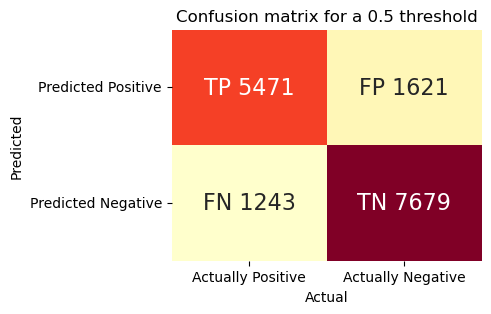

In [35]:
confusion_matrix_05 = compute_confusion_matrix(test_label, prediction_proba, 0.5)
plt.figure(figsize=(4,3))
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion matrix for a 0.5 threshold")
plt.show()

{0:1.3f}: 

0：位置参数（Positional Argument）。表示需要格式化的值来自第 0 个变量（即第一个传入的变量）。

:：引导符，表示后面是格式化规则。

1：最小宽度（Optional）。表示输出的字符串至少占用 1 个字符。如果实际数值超过宽度，则动态调整宽度，不会截断结果。

.3：小数点后保留 3 位。

f：输出格式为浮点数。

In [36]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative] = compute_all_scores(confusion_matrix_05, 0.5)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}".format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}".format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.821
For the positive case, the precision is 0.771, the recall is 0.815 and the F1 score is 0.793
For the negative case, the precision is 0.861, the recall is 0.826 and the F1 score is 0.843


### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [38]:
# np.linspace 是 NumPy 提供的一个函数，用于在指定范围内生成等间距的数值序列。
# threshold = np.linspace(0, 1, 100) 的作用是：在区间 [0, 1] 之间生成 100 个等间距的数值。
threshold = np.linspace(0, 1, 100)

In [41]:
columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_scores(compute_confusion_matrix(test_label, prediction_proba, t), t)], columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace= True) # 将原本的第一列threshold变为行索引

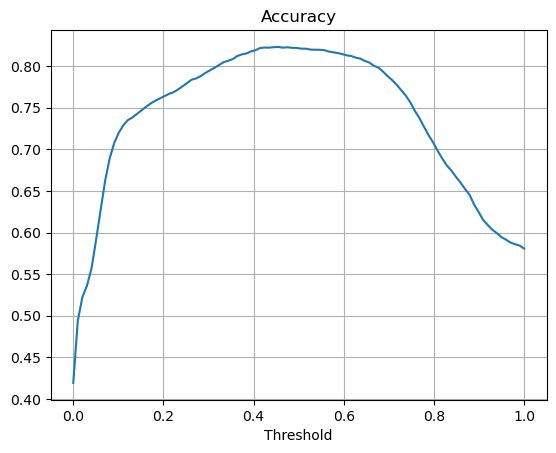

In [43]:
threshold_score.Accuracy.plot(grid=True).set_title("Accuracy") #这种plot形式自动把行索引作为横轴
plt.show()

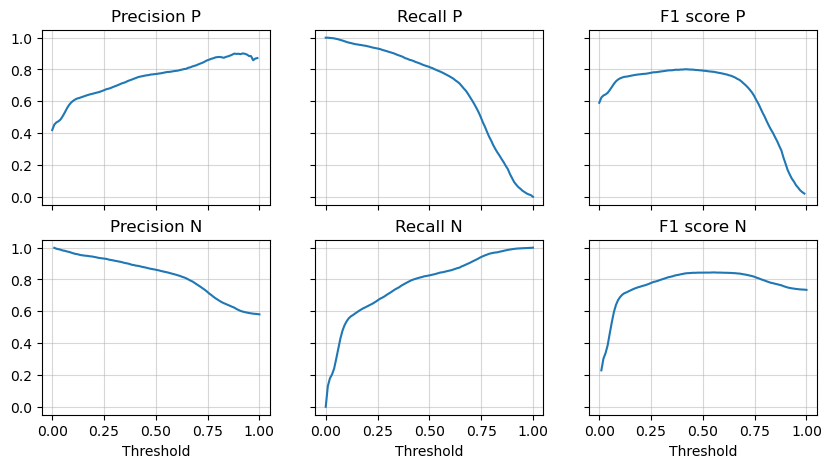

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

major_ticks = np.linspace(0,1,5)

for ax,col in zip(ax.flat, col_plot):
    threshold_score[col].plot(ax=ax, grid=True)
    ax.set_title(col)
    ax.set_xticks(major_ticks)
    ax.grid(which='major', alpha=0.5) # which='major'用来控制主刻度网格线

plt.show()

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [45]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)

LogisticRegression(max_iter=10000)

In [46]:
tmp = [] # 用于存储特征名称和对应权重的字典

for name, value in zip(train_features_std.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

,name,value
1,age_upon_intake_(years),-1.701614
6,sex_upon_outcome_Intact Male,-0.780557
5,sex_upon_outcome_Intact Female,-0.689668
26,intake_type_Wildlife,-0.671457
31,sex_upon_intake_Unknown,-0.490270


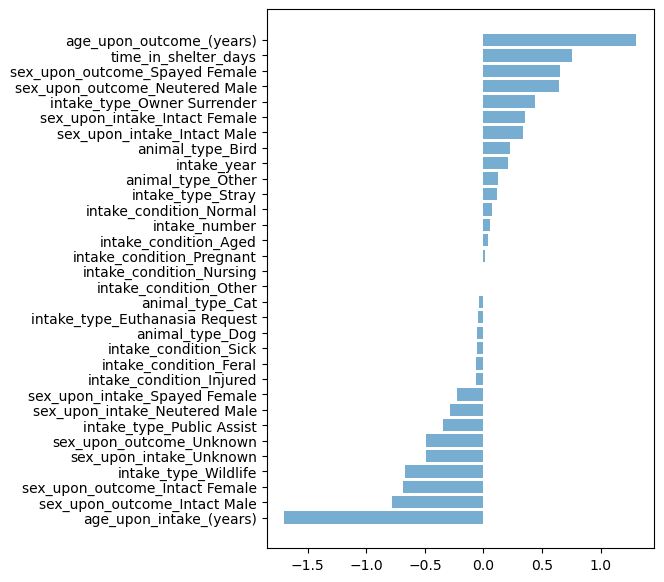

In [47]:
plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

In [48]:
# a)

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95

In [49]:
# a), b): accuracy = (50+100)/(50+10+5+100) = 0.909
# c): False Positive Rate (假阳性率) 是衡量分类器预测错误的一个指标，用来描述被错误分类为正类的负样本占所有负样本的比例。
#     FP rate = 10/(50+10) = 0.167
# d): True Positive Rate (TPR)，也称为 Recall（召回率）或 Sensitivity（敏感性），表示模型正确识别出正类样本的比例。 
#     TP rate = 100/(5+100) = 0.952